### Predictions

#### 4 beeps

In [1]:
from utils import BeepsProcessingStrategy

In [2]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep
import numpy as np


def beep_explore_job(
    a_tau, v_tau, m_tau, cm_weight, fb_weight, ff_weight, l_ex, n_sims, max_beeps
):

    beeps_range = np.arange(1, max_beeps + 1)
    soa = 48

    model = Paredes2022(
        time_range=(0, 750),
        neurons=30,
        position_range=(0, 30),
        tau=(a_tau, v_tau, m_tau),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_stim_n",
        repeat=n_sims,
        n_jobs=10,
        range=beeps_range,
        processing_strategy=BeepsProcessingStrategy(),
    )

    res = sp.run(
        auditory_soa=soa,
        auditory_intensity=2.325,
        visual_intensity=1.45,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        auditory_onset=10,
        visual_onset=34,
        noise=False,
        lateral_excitation=l_ex,
        lateral_inhibition=0.4,
        cross_modal_weight=cm_weight,
        feedback_weight=fb_weight,
        feedforward_weight=ff_weight,
        temporal_noise=True,
        temporal_noise_scale=5,
    )

    return res

In [3]:
max_beeps = 4
n_sims = 1024

lsqp_flashes, lspq_causes = beep_explore_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
    l_ex=0.5,
    max_beeps=max_beeps,
    n_sims=n_sims,
)

flashes_lspq = np.array(lsqp_flashes).reshape(n_sims, max_beeps)
flashes_per_beep_lspq = flashes_lspq.mean(axis=0)

causes_lspq = np.array(lspq_causes).reshape(n_sims, max_beeps)
causes_per_beep_lspq = causes_lspq.mean(axis=0)

Sweeping 'auditory_stim_n':   0%|          | 0/4096 [00:00<?, ?it/s]

In [6]:
print(flashes_per_beep_lspq)
print(causes_per_beep_lspq)

[1.24121094 1.23144531 1.23730469 1.24511719]
[0.94042969 0.90625    0.9375     0.90917969]


In [4]:
hsqp_flashes, hspq_causes = beep_explore_job(
    a_tau=6.560e00,
    v_tau=9.191e00,
    m_tau=1.200e02,
    cm_weight=1.036e-03,
    fb_weight=6.231e-01,
    ff_weight=3.892e00,
    l_ex=5.305e-01,
    max_beeps=max_beeps,
    n_sims=n_sims,
)

flashes_hspq = np.array(hsqp_flashes).reshape(n_sims, max_beeps)
flashes_per_beep_hspq = flashes_hspq.mean(axis=0)

causes_hspq = np.array(hspq_causes).reshape(n_sims, max_beeps)
causes_per_beep_hspq = causes_hspq.mean(axis=0)

Sweeping 'auditory_stim_n':   0%|          | 0/4096 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Plot

Text(-0.1, 1.1, 'B')

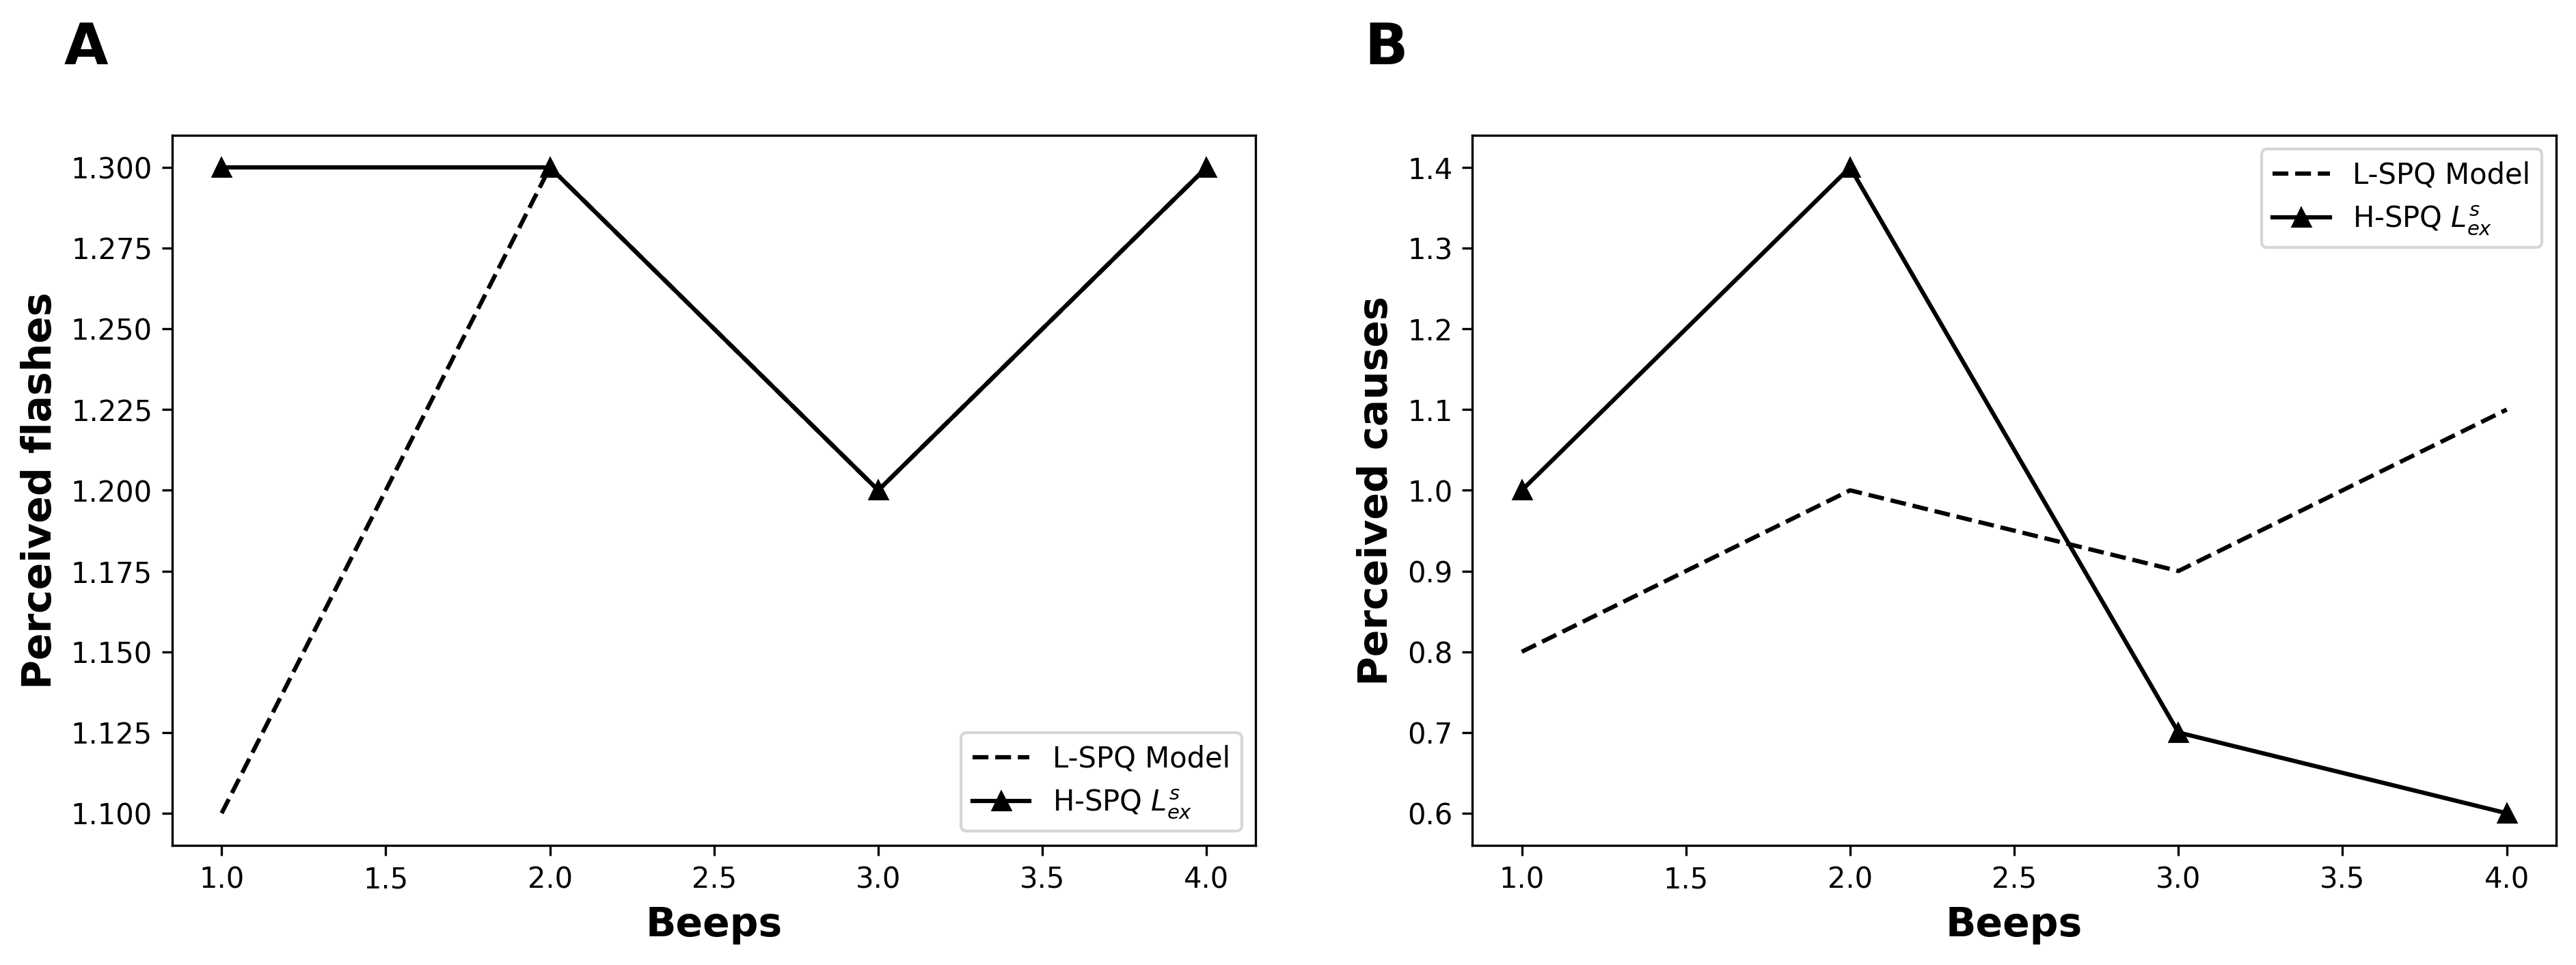

In [ ]:
import matplotlib.pyplot as plt
import string

beeps_range = np.arange(1, max_beeps + 1)

flashes_per_beep_lspq = np.array([1.24121094, 1.23144531, 1.23730469, 1.24511719])
causes_per_beep_lspq = np.array([0.94042969, 0.90625, 0.9375, 0.90917969])

flashes_per_beep_hspq = np.array()
causes_per_beep_hspq = np.array()

fig, axs = plt.subplots(1, 2, figsize=(15, 4.5), dpi=300)

ax1 = plt.subplot(121)
ax1.plot(beeps_range, flashes_per_beep_lspq, "--", label="L-SPQ Model", color="k")
ax1.plot(
    beeps_range,
    flashes_per_beep_hspq,
    label="H-SPQ " + r"$L_{ex}^{s}$",
    color="k",
    marker="^",
)

ax1.set_ylabel("Perceived flashes", size=14, weight="bold")
ax1.set_xlabel("Beeps", size=14, weight="bold")
# ax1.set_ylim(1, 2)
ax1.legend()
ax1.text(
    -0.1,
    1.1,
    string.ascii_uppercase[0],
    transform=ax1.transAxes,
    size=20,
    weight="bold",
)

ax2 = plt.subplot(122)
ax2.plot(beeps_range, causes_per_beep_lspq, "--", label="L-SPQ Model", color="k")
ax2.plot(
    beeps_range,
    causes_per_beep_hspq,
    label="H-SPQ " + r"$L_{ex}^{s}$",
    color="k",
    marker="^",
)

ax2.set_ylabel("Perceived causes", size=14, weight="bold")
ax2.set_xlabel("Beeps", size=14, weight="bold")
# ax2.set_ylim(1, 2)
ax2.legend()

ax2.text(
    -0.1,
    1.1,
    string.ascii_uppercase[1],
    transform=ax2.transAxes,
    size=20,
    weight="bold",
)

fig.savefig("drafts/FIG5.eps", bbox_inches="tight", format="eps")

In [ ]:
print(flashes_per_beep_lspq)
print(flashes_per_beep_hspq)

[1.1 1.3 1.2 1.3]
[1.3 1.3 1.2 1.3]


In [ ]:
print(causes_per_beep_lspq)
print(causes_per_beep_hspq)

[0.8 1.  0.9 1.1]
[1.  1.4 0.7 0.6]
